# Augmenting time-series data
In this file, the data is augmented in order to create more of it.

In [1]:
# Imports
import sys
sys.path.insert(1,'../')
import Tools.data_processing as dp
import Tools.data_movement as dm 
import pandas as pd
from datetime import datetime
from datetime import timedelta
import copy
import random
import matplotlib.pyplot as plt

## Helper Functions
The following functions provide useful tools for the augmentation process

In [2]:
def next_time_entry(current_entry: float) -> float:
    """
    This function returns the next time entry in julian time

    current_entry: a julina time float

    return: julian time + 15 minutes from past julian time
    """

    # convert julian to datetime
    date_time_init = dp.julian_to_datetime(current_entry)

    # find next date time (add 15 minutes)
    next_entry = date_time_init + timedelta(minutes=15)

    # convert date time to julian time
    final_julian_time = dp.datetime_to_julian(next_entry)

    # return julian time
    return final_julian_time


def reindex_augmented_data(data: pd.DataFrame, datatype: str) -> pd.DataFrame:
    """
    Reindex the augmented data so there are no overlaps

    data: the data to reindex
    datatype: fdom, turb, or stage

    returns: reindexed data
    """
    pass


def get_last_augment_index(dataframe) -> int:
    """
    Collects the last index of the augmented time series
    """
    return dataframe.shape[0]


## Loading in data
The knowledge-based approach uses the data in `Data/converted_data/julian_format/`, so that is where the data augmentation will go.

In [3]:
# Read in raw data
fDOM_data = dm.read_in_preprocessed_timeseries(
    "../Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv"
)
stage_data = dm.read_in_preprocessed_timeseries(
    "../Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv"
)
turb_data = dm.read_in_preprocessed_timeseries(
    "../Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv"
)

# align stage to fDOM
stage_data = dp.align_stage_to_fDOM(fDOM_data, stage_data)

# read in labeled fDOM
fDOM_labeled = pd.read_csv(
    "../Data/labeled_data/ground_truths/fDOM/fDOM_all_julian_0k-300k.csv"
)

# read in labeled turb
turb_labeled = pd.read_csv(
    "../Data/labeled_data/ground_truths/turb/turb_pp/julian_time/turb_pp_0k-300k_labeled.csv"
)

# New data folder:
AUGMENT_DATA_PATH = "../Data/augmented_data/julian_format/"


In [4]:
# Convert data into pandas dataframes for better indexing:
fDOM_raw = pd.DataFrame(fDOM_data)
fDOM_raw.columns = ["timestamp", "value"]

print(fDOM_raw.iloc[9399])

turb_raw = pd.DataFrame(turb_data)
turb_raw.columns = ["timestamp", "value"]

stage_raw = pd.DataFrame(stage_data)
stage_raw.columns = ["timestamp", "value"]

timestamp    2.456140e+06
value        3.444063e+01
Name: 9399, dtype: float64


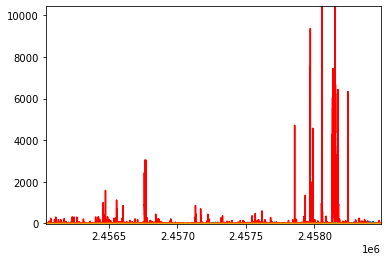

In [5]:
"""
Visualize data
"""
fig = plt.figure()
x = fDOM_raw['timestamp']
y = turb_raw['value']


line_fdom = plt.Line2D(fDOM_raw['timestamp'], fDOM_raw['value'])
line_turb = plt.Line2D(turb_raw['timestamp'], turb_raw['value'], color='red')
line_stage = plt.Line2D(stage_raw['timestamp'], stage_raw['value'], color='orange')
ax = fig.add_subplot(111)

ax.add_line(line_fdom)
ax.add_line(line_turb)
ax.add_line(line_stage)
ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y) - 10, max(y) + 10)

plt.show()

## Augmenting Data
We will augment data for each type of peak, and for each measurement.

Starting with fDOM:
1. PLP (plummeting peak)
2. PP (phantom peak)
3. SKP (skyrocketing peak)

TODO: augment more peak types when they are labeled

With turbidity:
1. PP

We start by creating our data frames to augment.

In [6]:
""" Helpful constants """
TIME_RANGE_INIT = 5  # the base distance of points to add between the peaks
ITERATIONS = 10 # number of times to loop over dataset and augment

In [7]:
""" 
Dataframes to be used by augmenter 

Re run this block to reset all augmented dataframes
"""

# labeled fDOM peaks
fdom_anon_peaks = fDOM_labeled[fDOM_labeled["label_of_peak"] != "NAP"]
# randomize the order, to add more

fdom_anon_peaks = fdom_anon_peaks.sample(frac=1).reset_index(drop=True)  # reset index as values were removed
print(fdom_anon_peaks)

# new dataframes for augmented labeled/raw fDOM
augmented_fDOM_raw = pd.DataFrame(columns=["timestamp", "value"])
augmented_fDOM_labeled = pd.DataFrame(
    columns=["timestamp_of_peak", "value_of_peak", "label_of_peak", "idx_of_peak"]
)

# dataframe for augmented stage
augmented_stage_raw_fdom = pd.DataFrame(columns=["timestamp", "value"])

# dataframes for augmented raw/labeled turbidity
augmented_turb_raw_fdom = pd.DataFrame(columns=["timestamp", "value"])
augmented_turb_labeled_fdom = pd.DataFrame(
    columns=["timestamp_of_peak", "value_of_peak", "label_of_peak", "idx_of_peak"]
)

# variable to keep the last entry in the dataframe for stage
# defaults to the last entry that was in fdom/turb raw csv files, in julian format
prev_added_entry = 2459096.9583333335

# a list of peaks that don't align with the fDOM raw file that was aligned with stage
# i believe its just peaks that don't align with stage in general for whatever reason
missed_fDOM_peaks = []


     timestamp_of_peak  value_of_peak label_of_peak  idx_of_peak
0         2.458147e+06       21.35628            PP       197241
1         2.456459e+06       20.08760            PP        38833
2         2.456184e+06       33.56401            PP        13623
3         2.456247e+06       25.02316            PP        19224
4         2.458345e+06       38.25498            PP       216260
..                 ...            ...           ...          ...
111       2.456143e+06       50.14263            PP         9686
112       2.458355e+06       31.23719            PP       217230
113       2.456183e+06       27.78394            PP        13524
114       2.458344e+06       40.80750            PP       216167
115       2.456130e+06       24.96976            PP         8437

[116 rows x 4 columns]


### Augmenting fDOM
The next codeblocks augment fDOM data.

In [8]:
for iteration in range(ITERATIONS):
    # iterate over each peak
    for i, row in fdom_anon_peaks.iterrows():
        # check to see if any overlap occurs between peaks
        prev_dist = TIME_RANGE_INIT
        next_dist = TIME_RANGE_INIT

        """Get raw fDOM data points"""
        timestamp_of_peak = fdom_anon_peaks.loc[i, "timestamp_of_peak"]
        label_of_peak = fdom_anon_peaks.loc[i, "label_of_peak"]

        # get index dataframes of each type
        fdom_index_df = fDOM_raw[fDOM_raw["timestamp"] == timestamp_of_peak]
        stage_index_df = stage_raw[stage_raw["timestamp"] == timestamp_of_peak]
        turb_index_df = turb_raw[turb_raw["timestamp"] == timestamp_of_peak]

        if len(fdom_index_df.index.to_list()) != 0:
            # get indices of each data type from index df's
            index_of_peak = fdom_index_df.index.tolist()[0]
            stage_index = stage_index_df.index.tolist()[0]
            turb_index = turb_index_df.index.tolist()[0]

            # use this timestamp to make a dataframe of raw stuff
            # get data from fDOM_raw file
            fDOM_raw_time_range = pd.DataFrame(
                fDOM_raw.iloc[index_of_peak - prev_dist : index_of_peak + next_dist]
            )

            # get stage data range
            stage_time_range = pd.DataFrame(
                stage_raw.iloc[stage_index - prev_dist : stage_index + next_dist]
            )

            # get turbidity data range
            turb_time_range = pd.DataFrame(
                turb_raw.iloc[turb_index - prev_dist : turb_index + next_dist]
            )

            # make a copy of the modified data
            new_fdom_raw = copy.deepcopy(fDOM_raw_time_range)
            new_stage = copy.deepcopy(stage_time_range)
            new_turb_raw = copy.deepcopy(turb_time_range)

            # peak index can change when we add in x data
            new_fdom_peak_index = -1
            new_peak_timestamp = -1

            # generate a random number to multiply the peak by, +- 0.1
            # set seed
            random.seed()
            random_val = random.uniform(-0.1, 0.1)

            new_peak_val = new_fdom_raw.loc[index_of_peak, "value"] * (1 + random_val)

            new_fdom_raw.loc[index_of_peak, "value"] = new_peak_val

            # TODO insert necessary values into turb and stage

            # get the next possible timestamp
            new_time_entry = next_time_entry(prev_added_entry)

            # update all timestamps for augmented data
            for i, row in new_fdom_raw.iterrows():
                # if timestamps equal, we have the relative peak
                if new_fdom_raw.loc[i, "timestamp"] == timestamp_of_peak:
                    # register index here
                    new_fdom_peak_index = get_last_augment_index(augmented_fDOM_raw)
                    new_peak_timestamp = new_time_entry

                # update timestamps
                new_fdom_raw.loc[i, "timestamp"] = new_time_entry
                new_stage.loc[i, "timestamp"] = new_time_entry
                new_turb_raw.loc[i, "timestamp"] = new_time_entry

                # get next time stamp
                new_time_entry = next_time_entry(new_time_entry)

            # add entries into raw fDOM
            augmented_fDOM_raw = pd.concat(
                [augmented_fDOM_raw, new_fdom_raw], ignore_index=True
            )

            new_label = pd.DataFrame(
                [
                    [
                        new_peak_timestamp,
                        new_peak_val,
                        label_of_peak,
                        new_fdom_peak_index,
                    ]
                ],
                columns=[
                    "timestamp_of_peak",
                    "value_of_peak",
                    "label_of_peak",
                    "idx_of_peak",
                ],
            )

            # add entries to labeled fDOM
            augmented_fDOM_labeled = pd.concat([augmented_fDOM_labeled, new_label])

            # add entries to stage
            augmented_stage_raw_fdom = pd.concat(
                [augmented_stage_raw_fdom, new_stage], ignore_index=True
            )

            # add entries to turb
            augmented_turb_raw_fdom = pd.concat(
                [augmented_turb_raw_fdom, new_turb_raw], ignore_index=True
            )

            # update prev time entry
            prev_added_entry = new_time_entry

        else:
            # we missed some data points, append them to the missed data dataframe
            missed_fDOM_peaks.append(timestamp_of_peak)


In [9]:
# Testing visualizing augmented data

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

print("Labeled Peaks Augmented")
print(augmented_fDOM_labeled)
print("\n")

print("Raw fDOM Augmented")
print(augmented_fDOM_raw)
print("\n")

print("Raw Stage Augmented")
print(augmented_stage_raw_fdom)
print("\n")

print("Raw Turbidity Augmented")
print(augmented_turb_raw_fdom)

Labeled Peaks Augmented
  timestamp_of_peak value_of_peak label_of_peak idx_of_peak
0     2459097.021       22.719           PP            0   
0     2459097.135       18.178           PP           10   
0      2459097.25       37.377           PP           20   
0     2459097.365       28.437           PP           30   
0     2459097.479       40.558           PP           40   
0     2459097.594       11.478          PLP           50   
0     2459097.708       32.465           PP           60   
0     2459097.823       58.929          SKP           70   
0     2459097.938       22.845           PP           80   
0     2459098.052       42.119           PP           90   
0     2459098.167       -0.038          PLP          100   
0     2459098.281       15.364           PP          110   
0     2459098.396        0.732          PLP          120   
0      2459098.51       14.664          PLP          130   
0     2459098.625        48.53           PP          140   
0      2459098.7

2459096.96875
2459189.7604166665


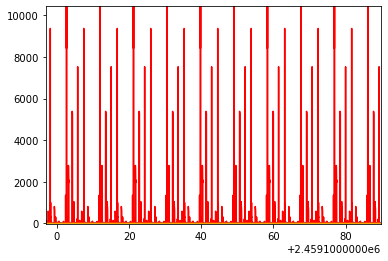

In [10]:
"""
Visualize data with matplotlib
"""
fig = plt.figure()
x = augmented_turb_raw_fdom['timestamp']
y = augmented_turb_raw_fdom['value']

print(min(x))
print(max(x))

line_fdom = plt.Line2D(augmented_fDOM_raw['timestamp'], augmented_fDOM_raw['value'])
line_turb = plt.Line2D(augmented_turb_raw_fdom['timestamp'], augmented_turb_raw_fdom['value'], color='red')
line_stage = plt.Line2D(augmented_stage_raw_fdom['timestamp'], augmented_stage_raw_fdom['value'], color='orange')
ax = fig.add_subplot(111)

ax.add_line(line_fdom)
ax.add_line(line_turb)
ax.add_line(line_stage)
ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y) - 10, max(y) + 10)

plt.show()

### Augment turbidity data
The following code blocks augment turbidity data.

In [21]:
"""
Dataframes for turbidity augmentation

Rerun this block to reset dataframes
"""
# labeled turb peaks
turb_anon_peaks = turb_labeled[turb_labeled["label_of_peak"] != "NPP"]
turb_anon_peaks = turb_anon_peaks.sample(frac=1).reset_index()

# labeled turb
augmented_turb_labeled = pd.DataFrame(
    columns=["timestamp_of_peak", "value_of_peak", "label_of_peak", "idx_of_peak"]
)

# raw turb
augmented_turb_raw = pd.DataFrame(columns=["timestamp", "value"])

# raw fdom
augmented_fDOM_raw_turb = pd.DataFrame(columns=["timestamp", "value"])

# raw stage
augmented_stage_raw_turb = pd.DataFrame(columns=["timestamp", "value"])

# variable to keep the last entry in the dataframe for stage
# defaults to the last entry that was in fdom/turb raw csv files, in julian format
prev_added_entry = 2459096.9583333335

# a list of peaks that don't align with the fDOM raw file that was aligned with stage
# i believe its just peaks that don't align with stage in general for whatever reason
missed_turb_peaks = []


     index  timestamp_of_peak  value_of_peak label_of_peak  idx_of_peak
0     916       2.458e+06           69.987          PP        192003   
1     840       2.458e+06           83.968          PP        178591   
2     705       2.458e+06           61.944          PP        146148   
3      81       2.456e+06           17.708          PP         25005   
4     170       2.456e+06          303.302          PP         35387   
5     323       2.457e+06           39.178          PP         55578   
6     595       2.457e+06           12.318          PP        110467   
7     222       2.456e+06         1000.151          PP         38883   
8     558       2.457e+06           90.016         PPP        103748   
9     467       2.457e+06            6.450          PP         74155   
10    440       2.457e+06            8.251          PP         73383   
11    302       2.457e+06           62.948          PP         49790   
12    457       2.457e+06           11.476          PP         7

In [25]:
""" Augment turbidity data by calling previously written function """
for iteration in range(ITERATIONS):
    # iterate over each peak
    for i, row in turb_anon_peaks.iterrows():
        # check to see if any overlap occurs between peaks
        prev_dist = TIME_RANGE_INIT
        next_dist = TIME_RANGE_INIT

        """Get raw turb data points"""
        timestamp_of_peak = turb_anon_peaks.loc[i, "timestamp_of_peak"]
        label_of_peak = turb_anon_peaks.loc[i, "label_of_peak"]

        # get index dataframes of each type
        fdom_index_df = fDOM_raw[fDOM_raw["timestamp"] == timestamp_of_peak]
        stage_index_df = stage_raw[stage_raw["timestamp"] == timestamp_of_peak]
        turb_index_df = turb_raw[turb_raw["timestamp"] == timestamp_of_peak]

        if len(turb_index_df.index.to_list()) != 0:
            # get indices of each data type from index df's
            index_of_peak = turb_index_df.index.tolist()[0]
            stage_index = stage_index_df.index.tolist()[0]
            fdom_index = fdom_index_df.index.tolist()[0]

            # use this timestamp to make a dataframe of raw stuff
            # get data from fDOM_raw file
            fDOM_raw_time_range = pd.DataFrame(
                fDOM_raw.iloc[fdom_index - prev_dist : fdom_index + next_dist]
            )

            # get stage data range
            stage_time_range = pd.DataFrame(
                stage_raw.iloc[stage_index - prev_dist : stage_index + next_dist]
            )

            # get turbidity data range
            turb_time_range = pd.DataFrame(
                turb_raw.iloc[index_of_peak - prev_dist : index_of_peak + next_dist]
            )

            # make a copy of the modified data
            new_fdom_raw = copy.deepcopy(fDOM_raw_time_range)
            new_stage = copy.deepcopy(stage_time_range)
            new_turb_raw = copy.deepcopy(turb_time_range)

            # peak index can change when we add in x data
            new_fdom_peak_index = -1
            new_peak_timestamp = -1

            # generate a random number to multiply the peak by, +- 0.1
            # set seed
            random.seed()
            random_val = random.uniform(-0.1, 0.1)

            new_peak_val = new_turb_raw.loc[index_of_peak, "value"] * (1 + random_val)

            new_turb_raw.loc[index_of_peak, "value"] = new_peak_val

            # TODO insert necessary values into fdom and stage

            # get the next possible timestamp
            new_time_entry = next_time_entry(prev_added_entry)

            # update all timestamps for augmented data
            for i, row in new_turb_raw.iterrows():
                # if timestamps equal, we have the relative peak
                if new_turb_raw.loc[i, "timestamp"] == timestamp_of_peak:
                    # register index here
                    new_turb_peak_index = get_last_augment_index(augmented_turb_raw)
                    new_peak_timestamp = new_time_entry

                # update timestamps
                new_fdom_raw.loc[i, "timestamp"] = new_time_entry
                new_stage.loc[i, "timestamp"] = new_time_entry
                new_turb_raw.loc[i, "timestamp"] = new_time_entry

                # get next time stamp
                new_time_entry = next_time_entry(new_time_entry)

            # add entries to turb
            augmented_turb_raw = pd.concat(
                [augmented_turb_raw, new_turb_raw], ignore_index=True
            )

            new_label = pd.DataFrame(
                [
                    [
                        new_peak_timestamp,
                        new_peak_val,
                        label_of_peak,
                        new_turb_peak_index,
                    ]
                ],
                columns=[
                    "timestamp_of_peak",
                    "value_of_peak",
                    "label_of_peak",
                    "idx_of_peak",
                ],
            )

            # add entries to labeled turb
            augmented_turb_labeled = pd.concat([augmented_turb_labeled, new_label])

            # add entries to stage
            augmented_stage_raw_turb = pd.concat(
                [augmented_stage_raw_turb, new_stage], ignore_index=True
            )

            # add entries into raw fDOM
            augmented_fDOM_raw_turb = pd.concat(
                [augmented_fDOM_raw_turb, new_fdom_raw], ignore_index=True
            )

            # update prev time entry
            prev_added_entry = new_time_entry

        else:
            # we missed some data points, append them to the missed data dataframe
            missed_fDOM_peaks.append(timestamp_of_peak)


        timestamp   value
191998  2.458e+06   0.969
191999  2.458e+06   1.101
192000  2.458e+06   1.057
192001  2.458e+06   1.057
192002  2.458e+06   7.410
192003  2.458e+06  69.987
192004  2.458e+06  11.412
192005  2.458e+06   4.050
192006  2.458e+06   4.006
192007  2.458e+06   4.801
        timestamp    value  
178586  2.458e+06  8.850e-05
178587  2.458e+06 -4.377e-02
178588  2.458e+06  1.315e-01
178589  2.458e+06  1.315e-01
178590  2.458e+06 -8.757e-02
178591  2.458e+06  8.397e+01
178592  2.458e+06  3.353e+01
178593  2.458e+06  2.108e+00
178594  2.458e+06  6.146e-01
178595  2.458e+06  2.628e-01
       timestamp   value 
25000  2.456e+06    4.700
25001  2.456e+06  115.158
25002  2.456e+06  205.391
25003  2.456e+06   21.808
25004  2.456e+06    3.900
25005  2.456e+06   17.708
25006  2.456e+06    0.840
25007  2.456e+06    6.932
25008  2.456e+06   90.924
25009  2.456e+06   30.397
       timestamp   value 
35382  2.456e+06  157.003
35383  2.456e+06  121.613
35384  2.456e+06  157.373
35385

KeyboardInterrupt: 

In [20]:
# Testing visualizing augmented data

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

print("Labeled Peaks Augmented")
print(augmented_turb_labeled)
print("\n")

print("Raw fDOM Augmented")
print(augmented_fDOM_raw_turb)
print("\n")

print("Raw Stage Augmented")
print(augmented_stage_raw_turb)
print("\n")

print("Raw Turbidity Augmented")
print(augmented_turb_raw)

Labeled Peaks Augmented
Empty DataFrame
Columns: [timestamp_of_peak, value_of_peak, label_of_peak, idx_of_peak]
Index: []


Raw fDOM Augmented
Empty DataFrame
Columns: [timestamp, value]
Index: []


Raw Stage Augmented
Empty DataFrame
Columns: [timestamp, value]
Index: []


Raw Turbidity Augmented
Empty DataFrame
Columns: [timestamp, value]
Index: []


In [ ]:
"""
Visualize data with matplotlib
"""
fig = plt.figure()
x = augmented_turb_raw['timestamp']
y = augmented_turb_raw['value']

print(min(x))
print(max(x))

line_fdom = plt.Line2D(augmented_fDOM_raw_turb['timestamp'], augmented_fDOM_raw_turb['value'])
line_turb = plt.Line2D(augmented_turb_raw['timestamp'], augmented_turb_raw['value'], color='red')
line_stage = plt.Line2D(augmented_stage_raw_turb['timestamp'], augmented_stage_raw_turb['value'], color='orange')
ax = fig.add_subplot(111)

ax.add_line(line_fdom)
ax.add_line(line_turb)
ax.add_line(line_stage)
ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y) - 10, max(y) + 10)

plt.show()

## Move augmented data into csv files
The following codeblock creates csv files for the augmented data.

### NOTE ON DATA:
Due to the random sampling used when augmenting fDOM and turbidity,

In [ ]:
""" Augmented Data Paths """


In [ ]:
# TODO: Implement this function
def write_augmented_data_to_csv():
    # call to_csv for each dataframe
    pass